This notebook will have my attempts at trying to troubleshoot the unexpected lower Lower Frequency in the virtual-multi bat audio. I'm not able to understand the source of this result, and so suspect one of three causes, which I will try to eliminate over the course of this notebook. 

- Error in bootstrapping code
- Error/mismatch in audio split-measuring between the observed and virtual audio files 
- Check the idea that a lower frequency defined by -X dB  peak frequency is susceptible to the slope of the exact shape of the spectrum. 
- Low sample size effect because there are only ~100 $N_{observed\ multi}$ and $N_{virtual\ multi}$ files

The causes are ordered in how likely I think they are - so here it goes. 

In [1]:
import numpy as np 
np.random.seed(82319)
import pandas as pd
import scipy.signal as signal
import tqdm
import matplotlib.pyplot as plt
import datetime as dt

In [2]:
print(f'This notebook was started at {dt.datetime.now()}')

This notebook was started at 2020-09-09 18:22:15.861629


In [3]:
# load the original data to get an idea
split_measure = pd.read_csv('non_silent_measurements_20dBthreshold.csv')
split_measure['type'] = 'observed'

virtual_split_measure = pd.read_csv('non_silent_virtual_multibat_measurements_20dBthreshold.csv')
virtual_split_measure['type'] = 'virtual'

all_measures = pd.concat([split_measure, virtual_split_measure]).reset_index(drop=True)

# a stupid hack to fix the pairing order in a deterministic way. 
# Among the three pairs possible, the order is always the following
# single-observed
# multi-observed
# multi-virtual

group_and_type = []
for i, row in all_measures.iterrows():
    row_type = row['type']
    num_bats = row['num_bats']
    if num_bats>1:
        single_or_multi = '1multi'
    else:
        single_or_multi = '0single'
    
    group_and_type.append(single_or_multi + '_' + row_type)

all_measures['group_type'] = group_and_type

In [4]:
all_measures

,Unnamed: 0,value,segment_number,measurement,file_name,unique_window_id,video_annot_id,num_bats,type,group_type
0,0,0.032661,0,rms,matching_annotaudio_Aditya_2018-08-16_21502300...,0_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_9,1,observed,0single_observed
1,1,0.102295,0,peak_amplitude,matching_annotaudio_Aditya_2018-08-16_21502300...,0_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_9,1,observed,0single_observed
2,2,90200.000000,0,minus_XdB_frequency,matching_annotaudio_Aditya_2018-08-16_21502300...,0_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_9,1,observed,0single_observed
3,3,104700.000000,0,dominant_frequencies,matching_annotaudio_Aditya_2018-08-16_21502300...,0_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_9,1,observed,0single_observed
4,4,0.020559,3,rms,matching_annotaudio_Aditya_2018-08-16_21502300...,3_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_12,2,observed,1multi_observed
...,...,...,...,...,...,...,...,...,...,...
27823,8569,0.192261,91,peak_amplitude,matching_annotaudio_Aditya_2018-08-17_34_133_h...,91_matching_annotaudio_Aditya_2018-08-17_34_13...,Aditya_2018-08-17_34_133,2,virtual,1multi_virtual
27824,8570,98420.000000,91,minus_XdB_frequency,matching_annotaudio_Aditya_2018-08-17_34_133_h...,91_matching_annotaudio_Aditya_2018-08-17_34_13...,Aditya_2018-08-17_34_133,2,virtual,1multi_virtual
27825,8571,109380.000000,91,dominant_frequencies,matching_annotaudio_Aditya_2018-08-17_34_133_h...,91_matching_annotaudio_Aditya_2018-08-17_34_13...,Aditya_2018-08-17_34_133,2,virtual,1multi_virtual
27826,8572,109660.000000,91,dominant_frequencies,matching_annotaudio_Aditya_2018-08-17_34_133_h...,91_matching_annotaudio_Aditya_2018-08-17_34_13...,Aditya_2018-08-17_34_133,2,virtual,1multi_virtual


In [5]:
# load the code used in the original notebook ('Comparing single and multi...')
from bootstrapping_splitmeasurements import *

### Error in bootstrapping code
There could be an error in the functions. Let's make an artificial dataset which mimics the structure of the ```all_measures``` DataFrame closely - but with some known results, ie. known differences in median etc. |

In [6]:
fake_single = np.random.normal(100000,2000, 3000)
fake_multi = np.random.normal(95000,2000, 3000)
fake_vmulti = np.random.normal(97500,2000, 3000)

def make_filename_and_segnums(values, num_files, num_segs, msmt_name):
    df = pd.DataFrame(data={'value':values})
    df['segment_number'] = np.concatenate([ np.arange(num_segs) for i in range(num_files)])
    df['file_name'] = np.concatenate([ np.tile(i,num_segs) for i in range(num_files)])
    df['measurement'] = msmt_name
    
    return df

fake_singledf = make_filename_and_segnums(fake_single, 300, 10, 'lower_frequency')
fake_singledf['num_bats'] = 1
fake_singledf['type'] = 'observed'
fake_multidf = make_filename_and_segnums(fake_multi, 300, 10, 'lower_frequency')
fake_multidf['num_bats'] = 2
fake_multidf['type'] = 'observed'
fake_vmultidf = make_filename_and_segnums(fake_vmulti, 300, 10, 'lower_frequency')
fake_vmultidf['num_bats'] = 2
fake_vmultidf['type'] = 'virtual'

all_fake = pd.concat((fake_singledf, fake_multidf, fake_vmultidf))

group_and_type = []
for i, row in all_fake.iterrows():
    row_type = row['type']
    num_bats = row['num_bats']
    if num_bats>1:
        single_or_multi = '1multi'
    else:
        single_or_multi = '0single'
    
    group_and_type.append(single_or_multi + '_' + row_type)

all_fake['group_type'] = group_and_type



In [7]:
all_fake

,value,segment_number,file_name,measurement,num_bats,type,group_type
0,99097.405892,0,0,lower_frequency,1,observed,0single_observed
1,98777.345960,1,0,lower_frequency,1,observed,0single_observed
2,94846.549754,2,0,lower_frequency,1,observed,0single_observed
3,102316.844209,3,0,lower_frequency,1,observed,0single_observed
4,100702.404258,4,0,lower_frequency,1,observed,0single_observed
...,...,...,...,...,...,...,...
2995,95160.449772,5,299,lower_frequency,2,virtual,1multi_virtual
2996,92784.850283,6,299,lower_frequency,2,virtual,1multi_virtual
2997,93444.050321,7,299,lower_frequency,2,virtual,1multi_virtual
2998,93284.395168,8,299,lower_frequency,2,virtual,1multi_virtual


In [8]:
%matplotlib notebook

In [9]:
plt.figure()
plt.boxplot([fake_single, fake_multi, fake_vmulti]);
plt.xticks([1,2,3], ['fake single','fake multi','fake v multi']);

<IPython.core.display.Javascript object>

In [10]:
all_measures.columns

Index(['Unnamed: 0', 'value', 'segment_number', 'measurement', 'file_name',
       'unique_window_id', 'video_annot_id', 'num_bats', 'type', 'group_type'],
      dtype='object')

In [11]:
all_measures

,Unnamed: 0,value,segment_number,measurement,file_name,unique_window_id,video_annot_id,num_bats,type,group_type
0,0,0.032661,0,rms,matching_annotaudio_Aditya_2018-08-16_21502300...,0_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_9,1,observed,0single_observed
1,1,0.102295,0,peak_amplitude,matching_annotaudio_Aditya_2018-08-16_21502300...,0_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_9,1,observed,0single_observed
2,2,90200.000000,0,minus_XdB_frequency,matching_annotaudio_Aditya_2018-08-16_21502300...,0_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_9,1,observed,0single_observed
3,3,104700.000000,0,dominant_frequencies,matching_annotaudio_Aditya_2018-08-16_21502300...,0_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_9,1,observed,0single_observed
4,4,0.020559,3,rms,matching_annotaudio_Aditya_2018-08-16_21502300...,3_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_12,2,observed,1multi_observed
...,...,...,...,...,...,...,...,...,...,...
27823,8569,0.192261,91,peak_amplitude,matching_annotaudio_Aditya_2018-08-17_34_133_h...,91_matching_annotaudio_Aditya_2018-08-17_34_13...,Aditya_2018-08-17_34_133,2,virtual,1multi_virtual
27824,8570,98420.000000,91,minus_XdB_frequency,matching_annotaudio_Aditya_2018-08-17_34_133_h...,91_matching_annotaudio_Aditya_2018-08-17_34_13...,Aditya_2018-08-17_34_133,2,virtual,1multi_virtual
27825,8571,109380.000000,91,dominant_frequencies,matching_annotaudio_Aditya_2018-08-17_34_133_h...,91_matching_annotaudio_Aditya_2018-08-17_34_13...,Aditya_2018-08-17_34_133,2,virtual,1multi_virtual
27826,8572,109660.000000,91,dominant_frequencies,matching_annotaudio_Aditya_2018-08-17_34_133_h...,91_matching_annotaudio_Aditya_2018-08-17_34_13...,Aditya_2018-08-17_34_133,2,virtual,1multi_virtual


### Are the group types being split correctly: yes
The order in which the sub DataFrames are output match.

In [12]:
split_into_grouptypes(all_fake)

[              value  segment_number  file_name      measurement  num_bats  \
 0      99097.405892               0          0  lower_frequency         1   
 1      98777.345960               1          0  lower_frequency         1   
 2      94846.549754               2          0  lower_frequency         1   
 3     102316.844209               3          0  lower_frequency         1   
 4     100702.404258               4          0  lower_frequency         1   
 ...             ...             ...        ...              ...       ...   
 2995  100965.514702               5        299  lower_frequency         1   
 2996   98528.658716               6        299  lower_frequency         1   
 2997   98308.288447               7        299  lower_frequency         1   
 2998   99617.844372               8        299  lower_frequency         1   
 2999  101097.685145               9        299  lower_frequency         1   
 
           type        group_type  
 0     observed  0single_o

### Are the group-type summary data being calculated correctly: yes.
The median values are calculated corrected, the values and order of output match those expected.

In [13]:
calc_group_type_summary(all_fake, 'lower_frequency', np.median, proc_fun=just_return_input)

(99882.40453382532, 94956.76887188801, 97394.35256063436)

In [14]:
list(map(np.median,[fake_single,fake_multi ,fake_vmulti]))

[99882.40453382532, 94956.76887188801, 97394.35256063436]

### Do the bootstrapped data reflect what is expected:
Yes. Very well - and data is also presented in the same order as expected.

In [15]:
medians = []
for i in tqdm.tqdm(range(200)):
    median_data = calculate_bootstrapped_median_across_grouptypes(all_fake, 'lower_frequency',
                                                                   np.median, just_return_input)
    medians.append(median_data)

100%|██████████| 200/200 [01:48<00:00,  1.85it/s]


In [16]:
calc_fakemedians = reshape_to_3_cols(medians)

In [17]:
plt.figure()
plt.boxplot(calc_fakemedians);plt.xticks([1,2,3], ['fake single','fake multi','fake v multi']);
plt.ylabel('Bootstrapped median interval')

<IPython.core.display.Javascript object>

Text(0, 0.5, 'Bootstrapped median interval')

# Summary 1:
### <font color=green> It's probably not the code used to get the results itself. The bootstrapping code itself seems okay!</font>

-------------------------
## Error/mismatch in audio split-measuring between the observed and virtual audio files 
This idea comes from the general dissatisfaction that I've always had from seeing that the observed (single+mult) data and virtual multi bat data have been split-measured with two separate notebooks. This is just mainly because there is a lot of pre-processing, and note-taking involved - and thus keeps it cleaner. I would like to actually analyse both observed and virtual data in one notebook - but instead of that, I'll go back and *check* everything thoroughly once more. The main thing to check for is if the same parameters are being fed into ```split_measure_audio``` module. 

#### Post-check: 
The ```**kwargs``` fed into the ```split_measure_audio``` module are the same. I've also run both notebooks back-to-back on multiple occasions and still gotten the weird pattern. 

# Summary 2:
### <font color=green> there's no mismatch in the analysis pipeline between observed and virtual audio data
</font>

------

-------------------------------------------------


## The idea that -X dB peak frequency itself is not a good way to measure lower frequency
One of the realisations I'm coming to is that the overall power spectrum shape of a window may vary a *lot*, depending on whether a) there's only one call in it b) if there are multiple calls: b1) if the constant frequencies are similar or b2) if the constant frequencies are different. And this is what I'd now like to test by creating simulated calls. 


In [18]:
# Create
import itsfm
from itsfm.simulate_calls import make_cffm_call
from itsfm.segment import segment_call_into_cf_fm

fs = 250000
call_props1 = {'cf':(100000, 0.01),
                     'upfm':(90000,0.001),
                     'downfm':(80000,0.0025)}

cffm_call1, freq_profile = make_cffm_call(call_props1, fs)
cffm_call1 *= signal.tukey(cffm_call1.size, 0.5)

w,s = itsfm.visualise_sound(cffm_call1, fs, fft_size=64)
s.set_title('CF @ 100kHz')

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'CF @ 100kHz')

In [19]:
call_props2 = {'cf':(101000, 0.01),
               'upfm':(90000,0.001),
               'downfm':(80000,0.0025)}

cffm_call2, freq_profile = make_cffm_call(call_props2, fs)
cffm_call2 *= signal.tukey(cffm_call2.size, 0.5)

w,s = itsfm.visualise_sound(cffm_call2, fs, fft_size=64)
s.set_title('CF @ 102 kHz')

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'CF @ 102 kHz')

Now, having creaed the simulated calls, let's measure the -46dB lower frequency of both, and then take a look at the -46 dB lower frequency of the two calls combined together. My prediction is that there will be a mismatch. 

In [20]:
import sys 
sys.path.append('../')
import measure_annot_audio
from measure_annot_audio.inbuilt_measurement_functions import lower_minusXdB_peakfrequency
from measure_annot_audio.inbuilt_measurement_functions import make_smoothened_spectrum

In [21]:
fs = 250000
keywords = {'fs':fs,
           'spectrum_smoothing_width':100,
           'db_range':46}

sim_calls = [cffm_call1, cffm_call2]
lower_freqs = [lower_minusXdB_peakfrequency(each, **keywords) for each in sim_calls]
print(lower_freqs)

# Now add the two audio clips together and then check  the -X dB lower frequency . 
two_calls = np.zeros(int(0.05*fs))
two_calls += np.random.normal(0,0.0001,two_calls.size)
two_calls[0:sim_calls[0].size] += sim_calls[0]
random_start_sample = int(np.random.choice(np.arange(0,two_calls.size-cffm_call2.size),1))
two_calls[random_start_sample:random_start_sample+cffm_call2.size] += sim_calls[1]

combined_lower = lower_minusXdB_peakfrequency(two_calls, **keywords)
print(combined_lower)

[{'minus_XdB_frequency': 86370.37037037038}, {'minus_XdB_frequency': 86074.07407407407}]
{'minus_XdB_frequency': 86260.0}


In [22]:
def gen_smooth_spec(audio, **kwargs):
    smooth_spectrum = make_smoothened_spectrum(audio, **kwargs)
    freqs_audio = np.fft.rfftfreq(audio.size, 1.0/fs)
    return freqs_audio, smooth_spectrum


In [23]:
plt.figure()
plt.specgram(two_calls, Fs=fs);
plt.ylabel('Frequency, Hz');plt.xlabel('Time, s')

plt.figure()
freqs, spec = gen_smooth_spec(two_calls,**keywords)
plt.plot(freqs, spec)
plt.vlines(combined_lower['minus_XdB_frequency'],-10,60, label='combined lower')
[plt.vlines(each['minus_XdB_frequency'],0,40, label='individual lower', color='r') for each in lower_freqs]
plt.legend()
plt.xlim(65000,110000);plt.xlabel('Frequency, Hz')
plt.ylabel('Power, dB')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0, 0.5, 'Power, dB')

In [24]:
plt.figure()
plt.specgram(two_calls, Fs=fs);
plt.hlines(combined_lower['minus_XdB_frequency'],0,0.05)

<IPython.core.display.Javascript object>

### It's not as straightforward...sometimes, the combined calls lower frequency is lower, the same or higher than the individual lower frequencies of the calls. Let's perform a quick simulation study to show this. 

In [25]:
upfm_durns = np.arange(10**-3, 0.0015, 10**-4)
downfm_durns = np.arange(10**-3, 3*10**-3, 10**-4)
cf_durns = np.linspace(0.005,0.025,100)
CF_freqrange = np.linspace(99000, 105000,100)
upfm_bandwidth = np.linspace(500, 2500, 100)
downfm_bandwidth = np.linspace(2500, 15000, 100)


In [26]:
np.random.choice(cf_durns,1)

array([0.01651515])

Create a bunch of single CF-FM calls with different properties.

In [34]:
num_calls = 400
all_single_calls = {}

fs = 250000

random_windowing = True

for i in range(num_calls):
    cf_freq = float(np.random.choice(CF_freqrange,1))
    cf_durn = float(np.random.choice(cf_durns,1))
    upfm_lowerfreq, upfm_durn = float(cf_freq-np.random.choice(upfm_bandwidth,1)), float(np.random.choice(upfm_durns,1))
    downfm_lowerf, downfm_durn = float(cf_freq-np.random.choice(downfm_bandwidth,1)), float(np.random.choice(downfm_durns,1))



    call_props = {'cf':(cf_freq,
                         cf_durn),
                   'upfm':( upfm_lowerfreq,
                            upfm_durn),
                   'downfm':(downfm_lowerf,
                             downfm_durn),}


    cffm_call, freq_profile = make_cffm_call(call_props, fs)
    if random_windowing:
        extent_of_windowing = np.random.choice(np.linspace(0.1,0.5,100),1)
    else:
        extent_of_windowing = 0.5
    cffm_call *= signal.tukey(cffm_call.size, extent_of_windowing)
    # place the single call in a 
    one_segment = np.random.normal(0, 10**(-60/20), int(fs*0.05)) # -60 dB rms noise level
    start_points = np.linspace(0,0.018,1000) # random starting points to place call
    call_insertion_point  = int(np.random.choice(start_points,1)*fs)
    one_segment[call_insertion_point:call_insertion_point+cffm_call.size] += cffm_call
    all_single_calls[i] = one_segment


<IPython.core.display.Javascript object>


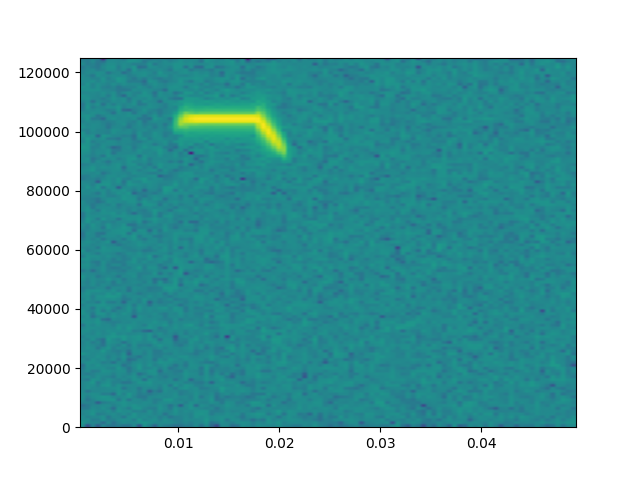

In [35]:
plt.figure()
plt.specgram(all_single_calls[100], Fs=fs);

Now make a bunch of virtual multi bat segments

In [36]:
n_virtualmulti = 100
virtual_multibat = {}

for i in range(n_virtualmulti):
    # choose two audio files
    file1, file2 = np.random.choice(np.arange(num_calls),2, replace=False)
    # add the two sounds together
    if np.random.random()<0.5:
        v_multi = all_single_calls[file1]+all_single_calls[file2]
    else:
        roll_amount = int(np.random.choice(np.arange(0,int(fs*0.025)),1))
        v_multi = all_single_calls[file1] + np.roll(all_single_calls[file2], roll_amount)
    virtual_multibat[i] = v_multi


<IPython.core.display.Javascript object>


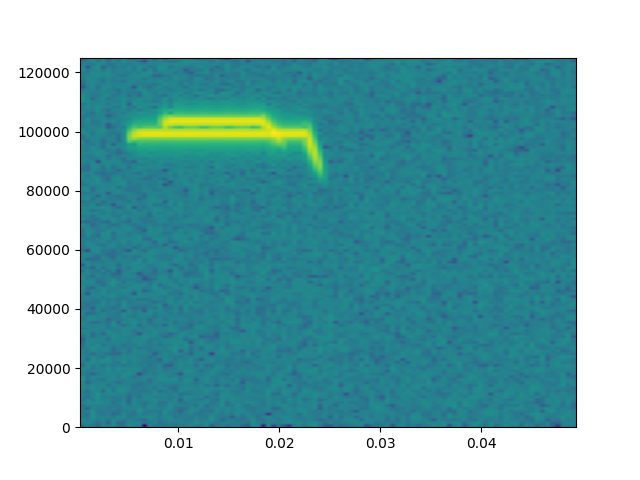

In [37]:
plt.figure()
plt.specgram(virtual_multibat[80], Fs=fs);

<font color=blue> Now measure the 'lower -X dB' frequency of the single bat audio, and compare it with the readings from the virtual multi bat audio measurements. 
</font>

In [38]:
lowerfreq_single = [lower_minusXdB_peakfrequency(audio, **keywords)['minus_XdB_frequency'] for i, audio in all_single_calls.items()]
lowerfreq_vmulti = [lower_minusXdB_peakfrequency(audio, **keywords)['minus_XdB_frequency'] for i, audio in virtual_multibat.items()]

<IPython.core.display.Javascript object>


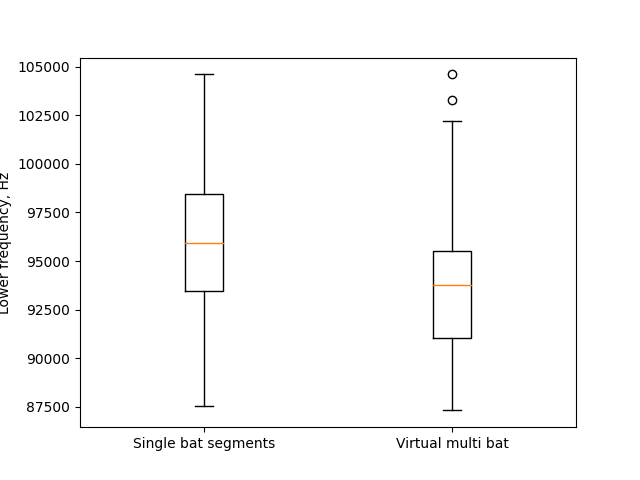

In [39]:
plt.figure()
plt.boxplot([lowerfreq_single, lowerfreq_vmulti]);
plt.ylabel('Lower frequency, Hz');plt.xticks([1,2],['Single bat segments','Virtual multi bat']);

So, there we go - I'm able to replicate my results of lower lower frequency just by adding in variation in the extent of windowing of the calls. If I were to replicate the same workflow without the random windowing of calls, I would still see a drop, but it'd be lesser (~500 Hz, instead of the ~1.5 kHz right now). The point is that I'm able to recreate what I'm seeing in the current results - virtual multi bat audio segments have a lower lower frequency than single bat audio segments. 

### *TO DO: COME UP WITH A +X DB FROM NOISE TYPE LOWER FREQUENCY MEASURE*

# Summary 3:
### <font color=green> The lower frequency calculated with -X dB peak frequency is not robust for multiple call audio
</font>